### The wine data set is a good one to begin one's journey into unsupervised learning.

Further details on the data set can be found at: https://archive.ics.uci.edu/dataset/109/wine

The dataset has been loaded into Scikit-Learn where one may use supervised learning if the target values are used. Without, we can treat the problem as an unsupervised one.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

In [2]:
# load the dataset
wine = datasets.load_wine(as_frame=True)

# since we want to proceed with unsupervised learning, we drop the target column and only retain the other 13 features
w_df = pd.DataFrame(data=wine.data)

In [3]:
w_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


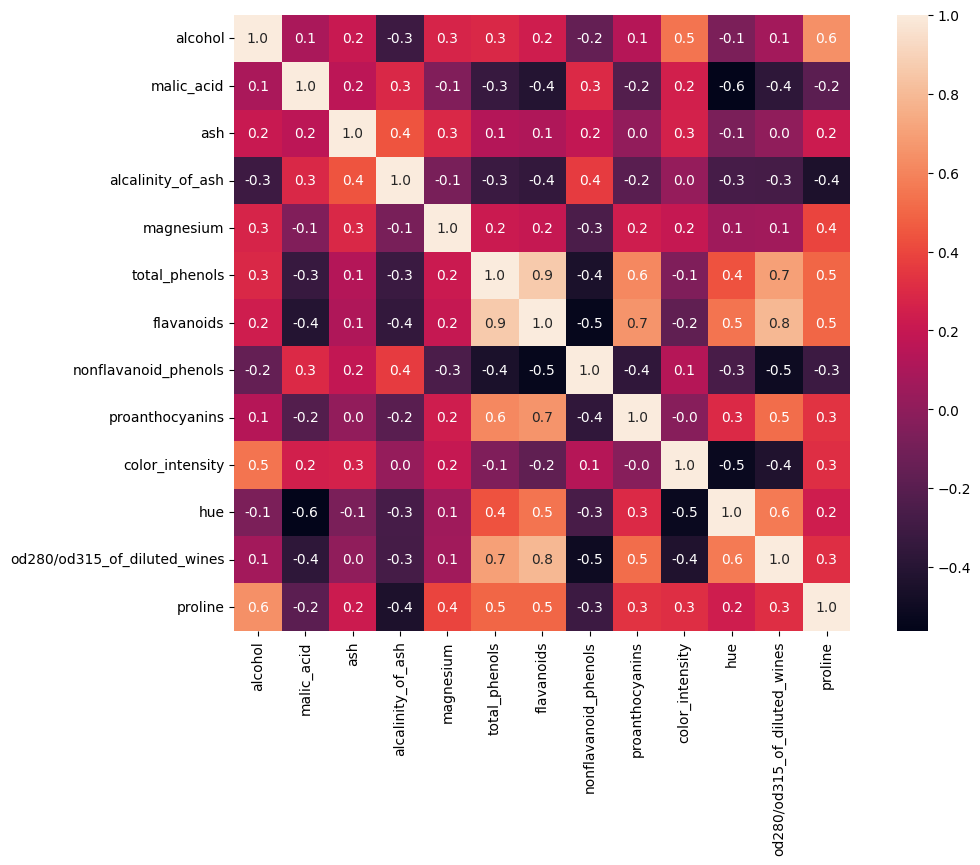

In [4]:
# let's check how correlated these wine properties are to each other.
plt.figure(figsize=(12,8))
sns.heatmap(w_df.corr(),annot=True, square=True, fmt='.1f')
plt.show()

In [5]:
# from our supervised learning on this dataset, we learned that some features are more important than others. We discard the features that did not contribute much to the model.
wine_df = w_df.drop(['ash','proanthocyanins','total_phenols','nonflavanoid_phenols','alcalinity_of_ash','malic_acid'],axis=1)
wine_df.head()

,alcohol,magnesium,flavanoids,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,127.0,3.06,5.64,1.04,3.92,1065.0
1,13.20,100.0,2.76,4.38,1.05,3.40,1050.0
2,13.16,101.0,3.24,5.68,1.03,3.17,1185.0
3,14.37,113.0,3.49,7.80,0.86,3.45,1480.0
4,13.24,118.0,2.69,4.32,1.04,2.93,735.0


In [6]:
# let's check their correlation again
wine_corr = wine_df.corr()

<Axes: >

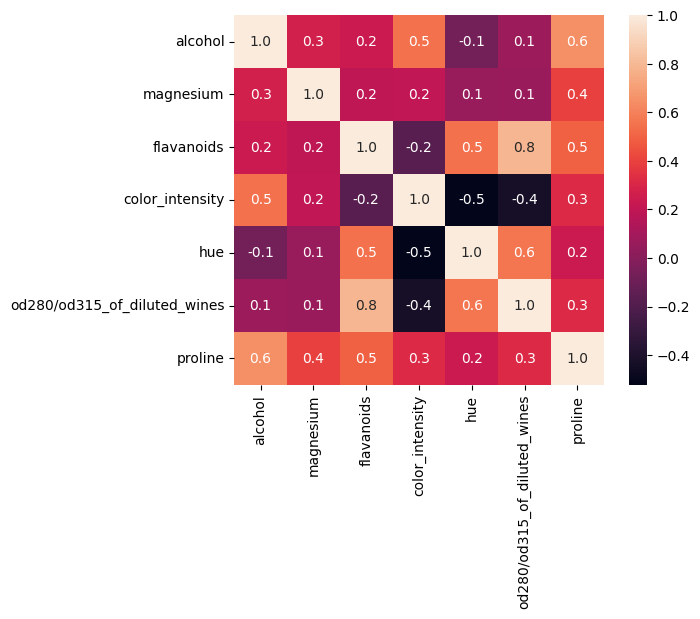

In [7]:
# heatmap
sns.heatmap(wine_corr,annot=True, square=True, fmt='.1f')

We got rid of the features not important in classification. The remaining features were chosen based on their feature importances.

### PCA

We can't visualize 7 dimensions, so let's trim this down a bit. This is where PCA comes in.

In [8]:
# let's decompose the data into the top 2 principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# fit and transform the data into these two components
X_new = pca.fit_transform(wine_df)

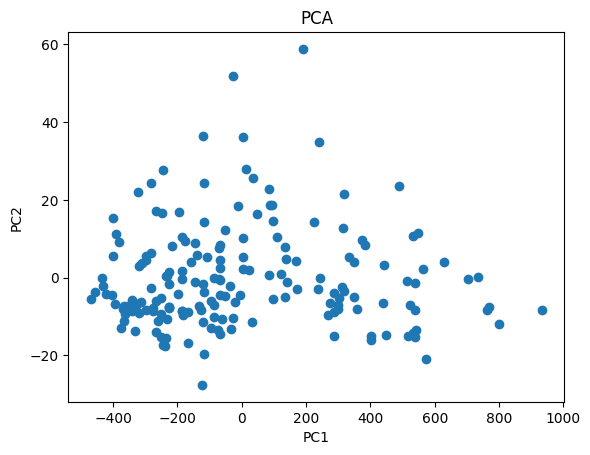

In [9]:
plt.title('PCA')
plt.scatter(X_new[:,0],X_new[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

We see above that the data is not well separated even after doing PCA. We might have to do some more preprocessing to make it work better.

In [10]:
# preprocess the data
from sklearn.preprocessing import QuantileTransformer, quantile_transform

qt = QuantileTransformer(n_quantiles=100)
X=qt.fit_transform(wine_df)

In [11]:
# Check shapes to make sure everything is ok
wine_df.shape

(178, 7)

In [12]:
# transformed data
X.shape

(178, 7)

You can find more about `QuantileTransformer` here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

In [13]:
# now let's try PCA again on this data
pca2 = PCA(n_components=2)

# fit and transform the data into these two components
X_new2 = pca2.fit_transform(X)

We're using two components only but you might want to check how many components need to be retained for a particular problem.

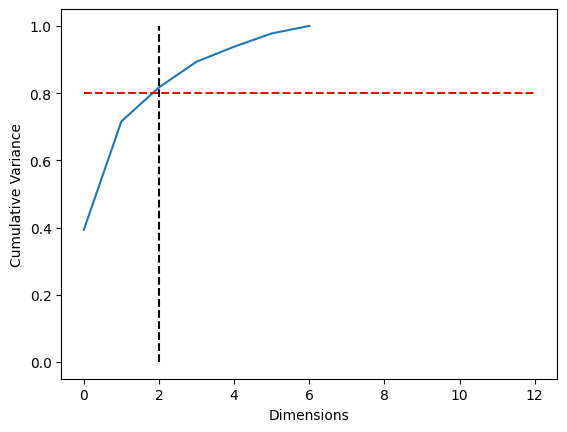

In [14]:
# how many dimensions are needed for some% explanation of the data
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumsum)
plt.vlines(2,0,1,color='k',linestyles='dashed')
plt.hlines(0.8,0,12,color='r',linestyles='dashed')
plt.xlabel('Dimensions')
plt.ylabel('Cumulative Variance')
plt.show()

A plot like above can guide you on how many components should you retain to describe how much of the data. For example, to explain over 80% of the variance in the data, you need at least the first three components.

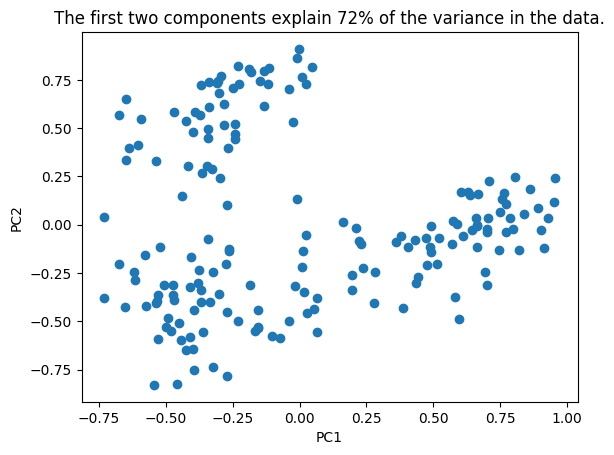

In [15]:
# total variance explained by these components
expl_var2 = pca2.explained_variance_ratio_.sum()

# plot
plt.title(f'The first two components explain {expl_var2:.0%} of the variance in the data.')
plt.scatter(X_new2[:,0],X_new2[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Much better! Now we move on to clustering.

### PCA and K-means clustering

Before attempting to separate the data into clusters, you might want to do a hyperparameter optimization. One quick test is to try some k values and check the silhouette scores

In [16]:
from sklearn import metrics
from sklearn.cluster import k_means, KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [17]:
# let's iterate over some k-values and print their silhouette scores to pick the best k parameter
ks = np.arange(2,10,1)
for i, ks in enumerate(ks):
    centroid, label, inertia = k_means(X_new2, n_clusters=ks, n_init="auto", random_state=42)
    silhouette_avg = silhouette_score(X_new2, label)
    print(f'silhouette score for k={ks} is: {silhouette_avg:.2f}')

silhouette score for k=2 is: 0.44
silhouette score for k=3 is: 0.61
silhouette score for k=4 is: 0.53
silhouette score for k=5 is: 0.47
silhouette score for k=6 is: 0.42
silhouette score for k=7 is: 0.43
silhouette score for k=8 is: 0.42
silhouette score for k=9 is: 0.40


$k=3$ has the maximum score so we proceed with that value

In [18]:
# try k means first
k = 3
clusters = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X_new2)

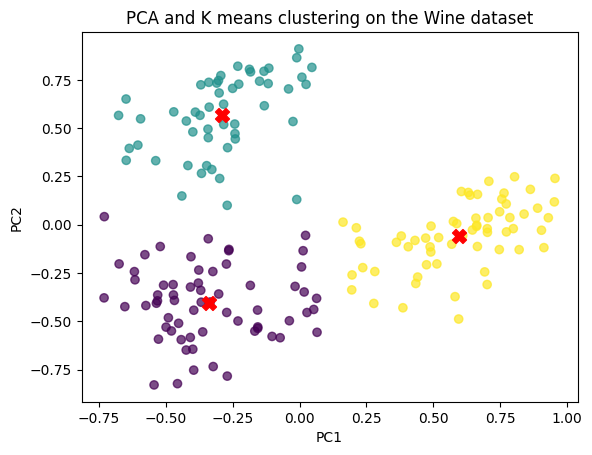

In [19]:
# how much of the data is explained by these components
centroid = clusters.cluster_centers_
label = clusters.labels_

plt.title('PCA and K means clustering on the Wine dataset')
plt.scatter(X_new2[:,0],X_new2[:,1],c=label,alpha=0.7)
plt.scatter(centroid[:,0],centroid[:,1],c='r',marker='X',s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Actually the data does contain truth values, we just didn't use them. Let's compare how our clustering performed vs the truth values.

In [20]:
# include the truth values and load all data
w_tar = pd.DataFrame(data=wine.target)

w_tar.head()

,target
0,0
1,0
2,0
3,0
4,0


In [21]:
# target indices
t_idx=w_tar['target']

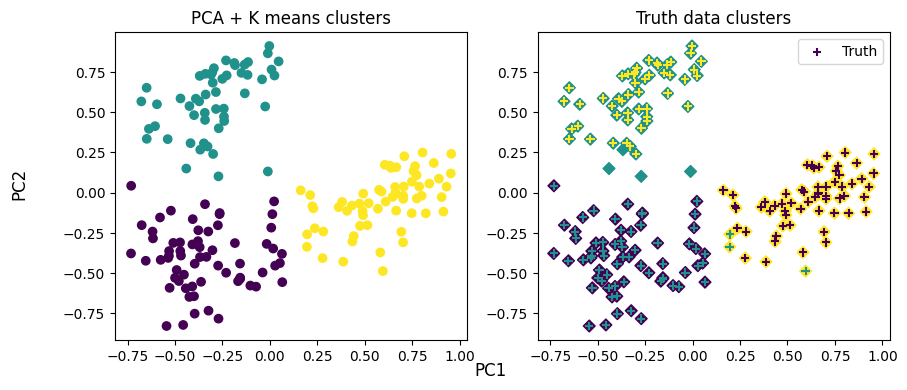

In [22]:
# check the clustering vs truth data
fig, ax=plt.subplots(1,2,figsize=(10,4))

ax=ax.flatten()

ax[0].set_title('PCA + K means clusters')
ax[1].set_title('Truth data clusters')
ax[0].scatter(X_new2[:,0],X_new2[:,1],c=label)
ax[1].scatter(X_new2[:,0],X_new2[:,1],marker='D',c=label)
ax[1].scatter(X_new2[:,0],X_new2[:,1],marker='+',c=t_idx,label='Truth')
ax[1].legend()
fig.supxlabel('PC1')
fig.supylabel('PC2')
plt.show()

In [23]:
# the truth labels are different than the labels from our clustering. This affects the coloring.
# For example
label

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [24]:
print(t_idx)

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64


We see from above:
    Label 2 from our clustering is the same as label 0 from the truth values.
    Label 0 from our clustering is the same as label 1 from the truth values.
    Label 1 from our clustering is the same as label 2 from the truth values.

Let's match them up.

In [25]:
cluster_labels = [label == 2, label == 0, label == 1]
truth_labels = [0, 1, 2]
pca_labels = np.select(cluster_labels, truth_labels)

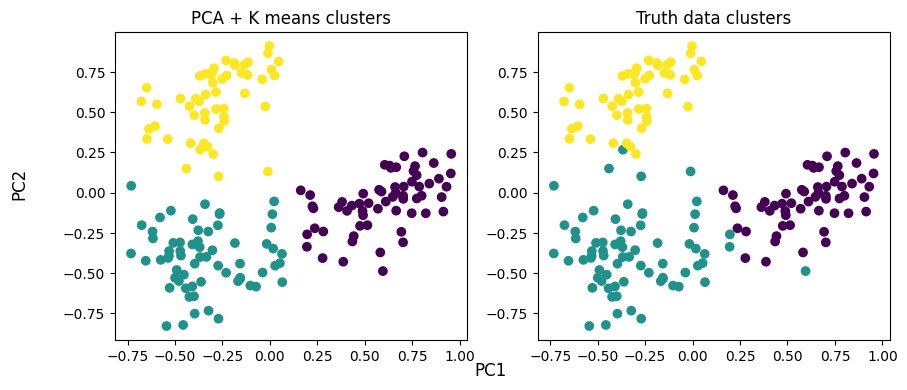

In [26]:
# check the clustering vs truth data
fig, ax=plt.subplots(1,2,figsize=(10,4))

ax=ax.flatten()

ax[0].set_title('PCA + K means clusters')
ax[1].set_title('Truth data clusters')
ax[0].scatter(X_new2[:,0],X_new2[:,1],c=pca_labels,label='Clustered data')
ax[1].scatter(X_new2[:,0],X_new2[:,1],c=t_idx,label='Truth')

fig.supxlabel('PC1')
fig.supylabel('PC2')
plt.show()

We saw that some points are misclassified on our clustering and here it is more easier to visually check that.

In [27]:
# check what indices data is giving issues
comp_df = pd.DataFrame({
    'pca_clusters': pca_labels,
    'target_labels': t_idx
})
comp_df.head()

,pca_clusters,target_labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [28]:
# check where the data is mismatched
mismatched_pca = comp_df[comp_df['pca_clusters'] != comp_df['target_labels']]
mismatched_pca

,pca_clusters,target_labels
61,2,1
68,2,1
70,2,1
73,0,1
83,2,1
95,0,1
121,0,1


In [29]:
print(f'Accuracy of classification using PCA: {1-len(mismatched_pca.index)/len(w_df.index):.1%}')

Accuracy of classification using PCA: 96.1%


### Kernel PCA and K-means clustering

Above, we used PCA for dimensionality reduction. With Kernel PCA, we can perform nonlinear projections for the same purpose. See here for neat example: https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html

In [30]:
from sklearn.decomposition import KernelPCA

In [31]:
# use kernel PCA
transformer=KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_kp = transformer.fit_transform(X)

Parameter `gamma` must once again be tuned for optimal results. However, if you do not have the truth labels as we will pretend here, tuning that value is going to be difficult.

In [32]:
# let's iterate over some k-values and print their silhouette scores to pick the best k parameter
ks = np.arange(2,10,1)
for i, ks in enumerate(ks):
    centroid, label, inertia = k_means(X_kp, n_clusters=ks, n_init="auto", random_state=42)
    silhouette_avg = silhouette_score(X_kp, label)
    print(f'silhouette score for k={ks} is: {silhouette_avg:.2f}')

silhouette score for k=2 is: 0.45
silhouette score for k=3 is: 0.62
silhouette score for k=4 is: 0.53
silhouette score for k=5 is: 0.48
silhouette score for k=6 is: 0.42
silhouette score for k=7 is: 0.43
silhouette score for k=8 is: 0.42
silhouette score for k=9 is: 0.41


$k=3$ has the maximum score so we proceed with that value

In [33]:
# try k means first
k = 3
clusters = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X_kp)

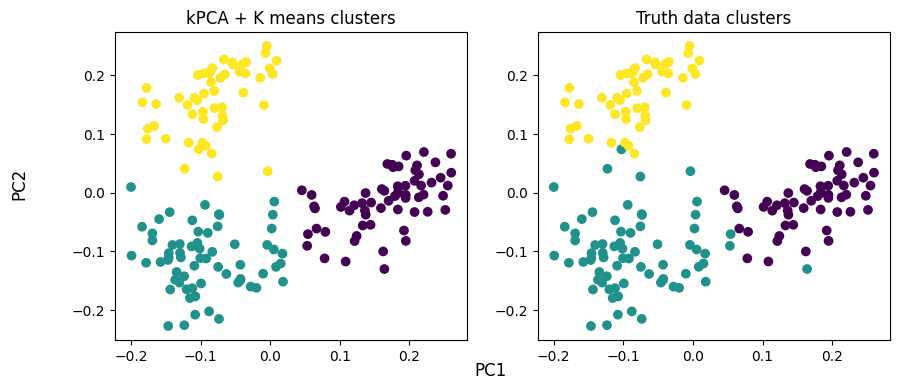

In [34]:
# check the clustering vs truth data
fig, ax=plt.subplots(1,2,figsize=(10,4))

ax=ax.flatten()

ax[0].set_title('kPCA + K means clusters')
ax[1].set_title('Truth data clusters')
ax[0].scatter(X_kp[:,0],X_kp[:,1],c=pca_labels,label='Clustered data')
ax[1].scatter(X_kp[:,0],X_kp[:,1],c=t_idx,label='Truth')

fig.supxlabel('PC1')
fig.supylabel('PC2')
plt.show()

We match the indices again for visualization help.

In [35]:
cluster_labels = [clusters.labels_ == 2, clusters.labels_ == 0, clusters.labels_ == 1]
truth_labels = [0, 1, 2]
kpca_labels = np.select(cluster_labels, truth_labels)

In [36]:
# check what indices data is giving issues
comp_df = pd.DataFrame({
    'kpca_clusters': kpca_labels,
    'target_labels': t_idx
})
comp_df.head()

,kpca_clusters,target_labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [37]:
# check where the data is mismatched
mismatched_kpca = comp_df[comp_df['kpca_clusters'] != comp_df['target_labels']]
mismatched_kpca

,kpca_clusters,target_labels
61,2,1
68,2,1
70,2,1
73,0,1
83,2,1
95,0,1
121,0,1


In [38]:
print(f'Accuracy of classification using Kernel PCA: {1-len(mismatched_kpca.index)/len(w_df.index):.1%}')

Accuracy of classification using Kernel PCA: 96.1%


Test different gamma values and do clustering on them. Check the two sets of plots below.

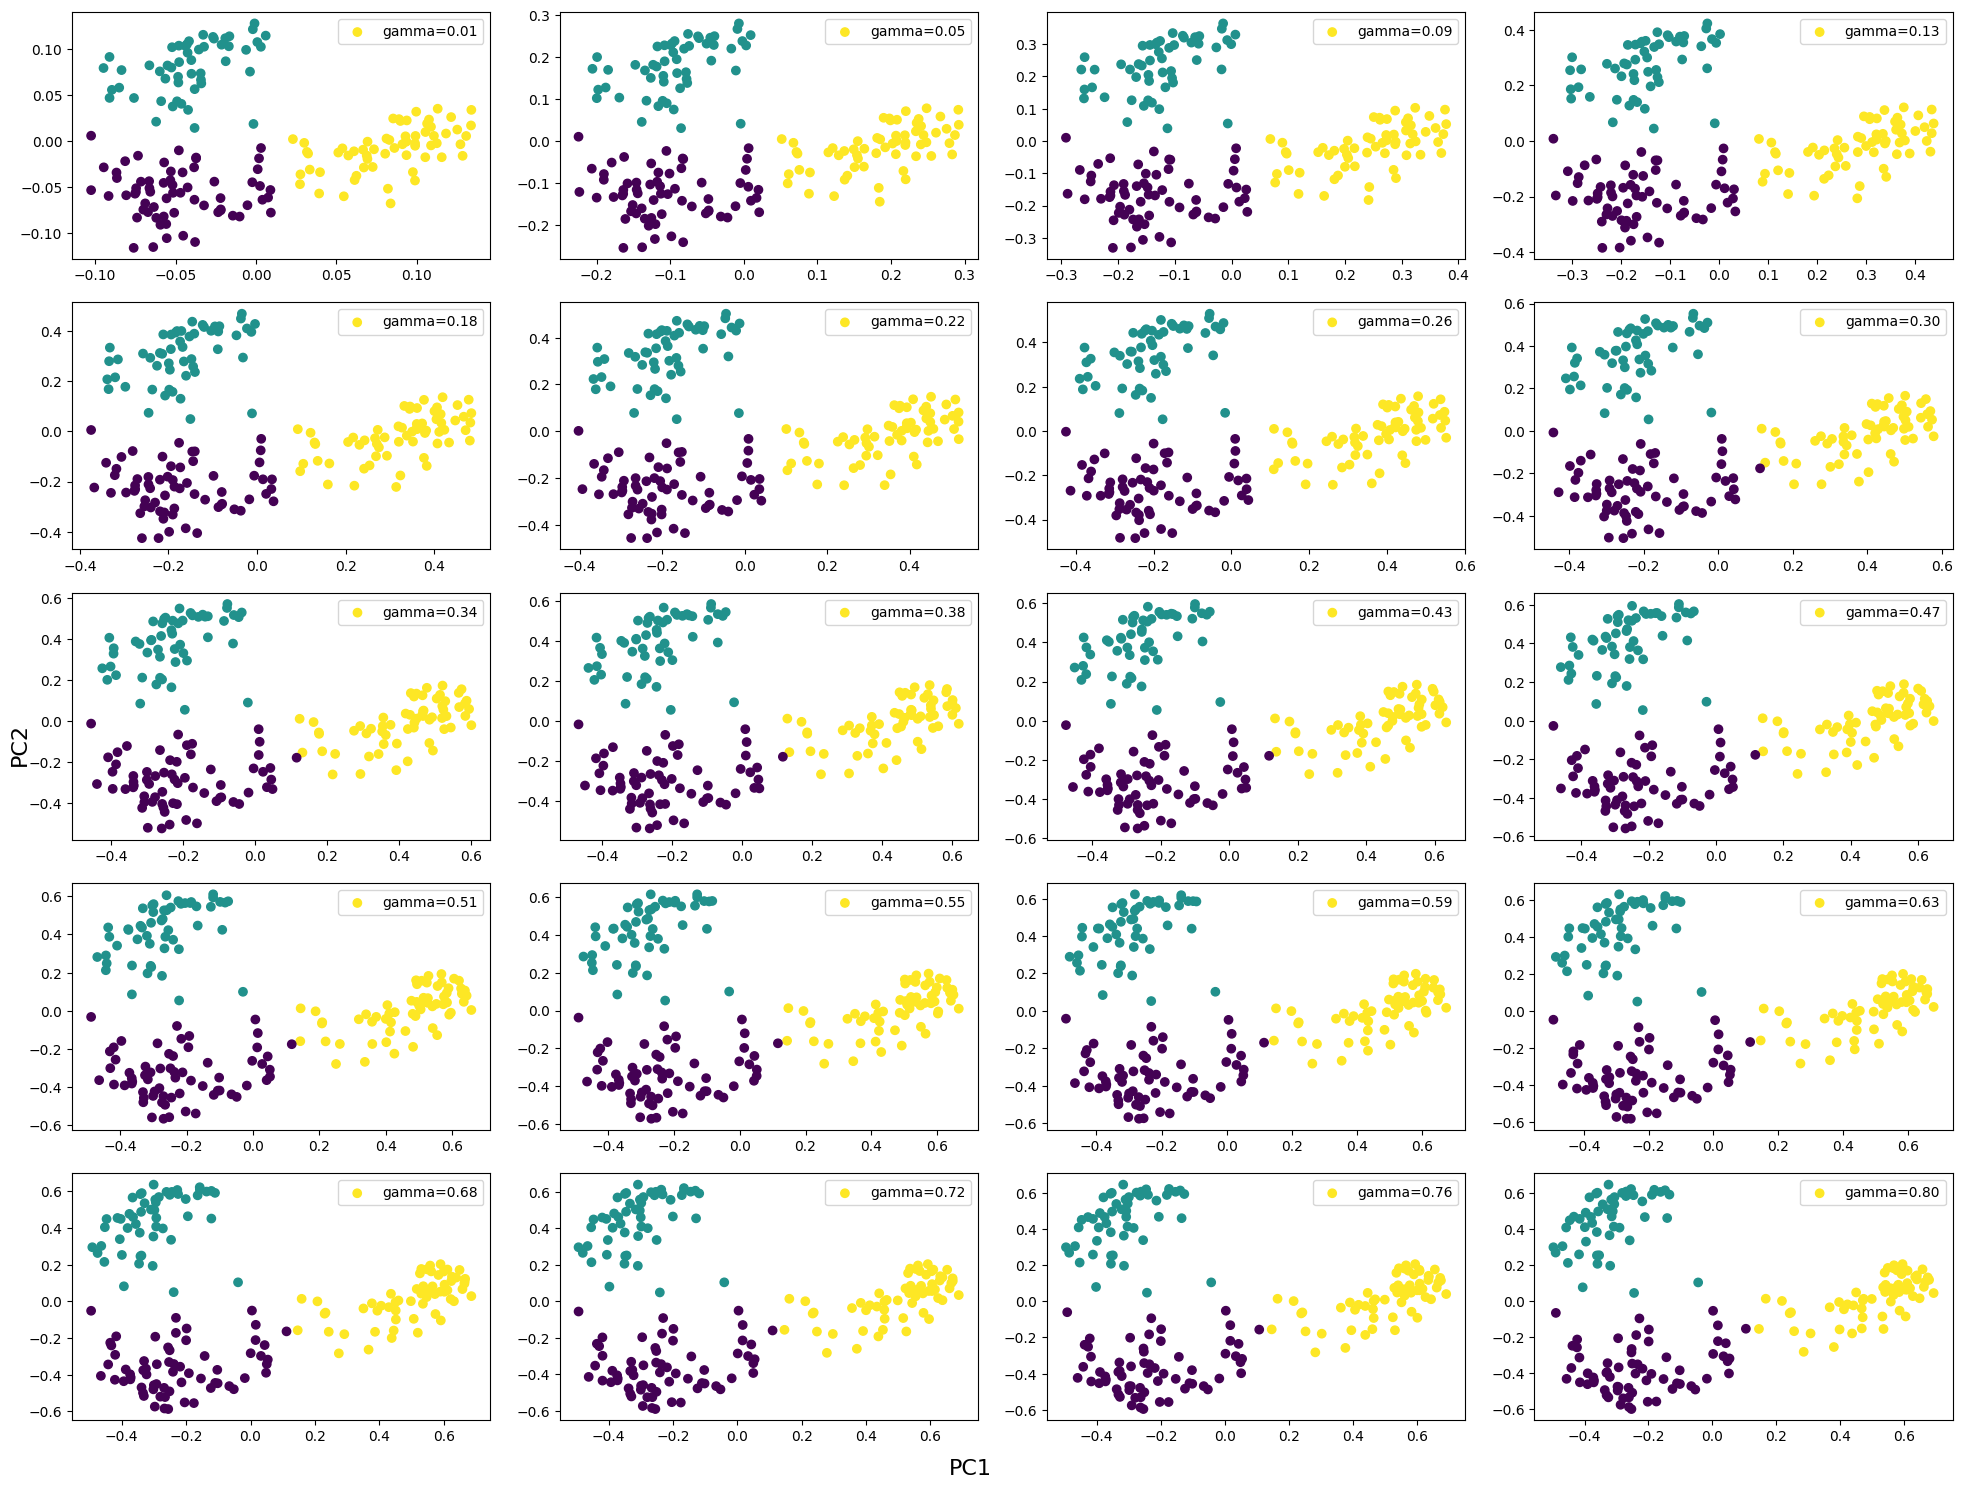

In [39]:
# different values of gamma
gamma_vals = np.linspace(0.01,0.8,20)

fig, ax = plt.subplots(5,4,figsize=(20,15))
ax=ax.flatten()

for i,j in enumerate(gamma_vals):
    transformer=KernelPCA(n_components=2, kernel='rbf', gamma=j)
    X_kp = transformer.fit_transform(X)
    clusters = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(X_kp)
    # plot the two components
    ax[i].scatter(X_kp[: ,0],X_kp[:,1],c=clusters.labels_,label=f'gamma={j:.2f}')
    ax[i].legend()

fig.supxlabel('PC1',fontsize=16)
fig.supylabel('PC2',fontsize=16)
fig.tight_layout()

We can test it against the truth plots below.

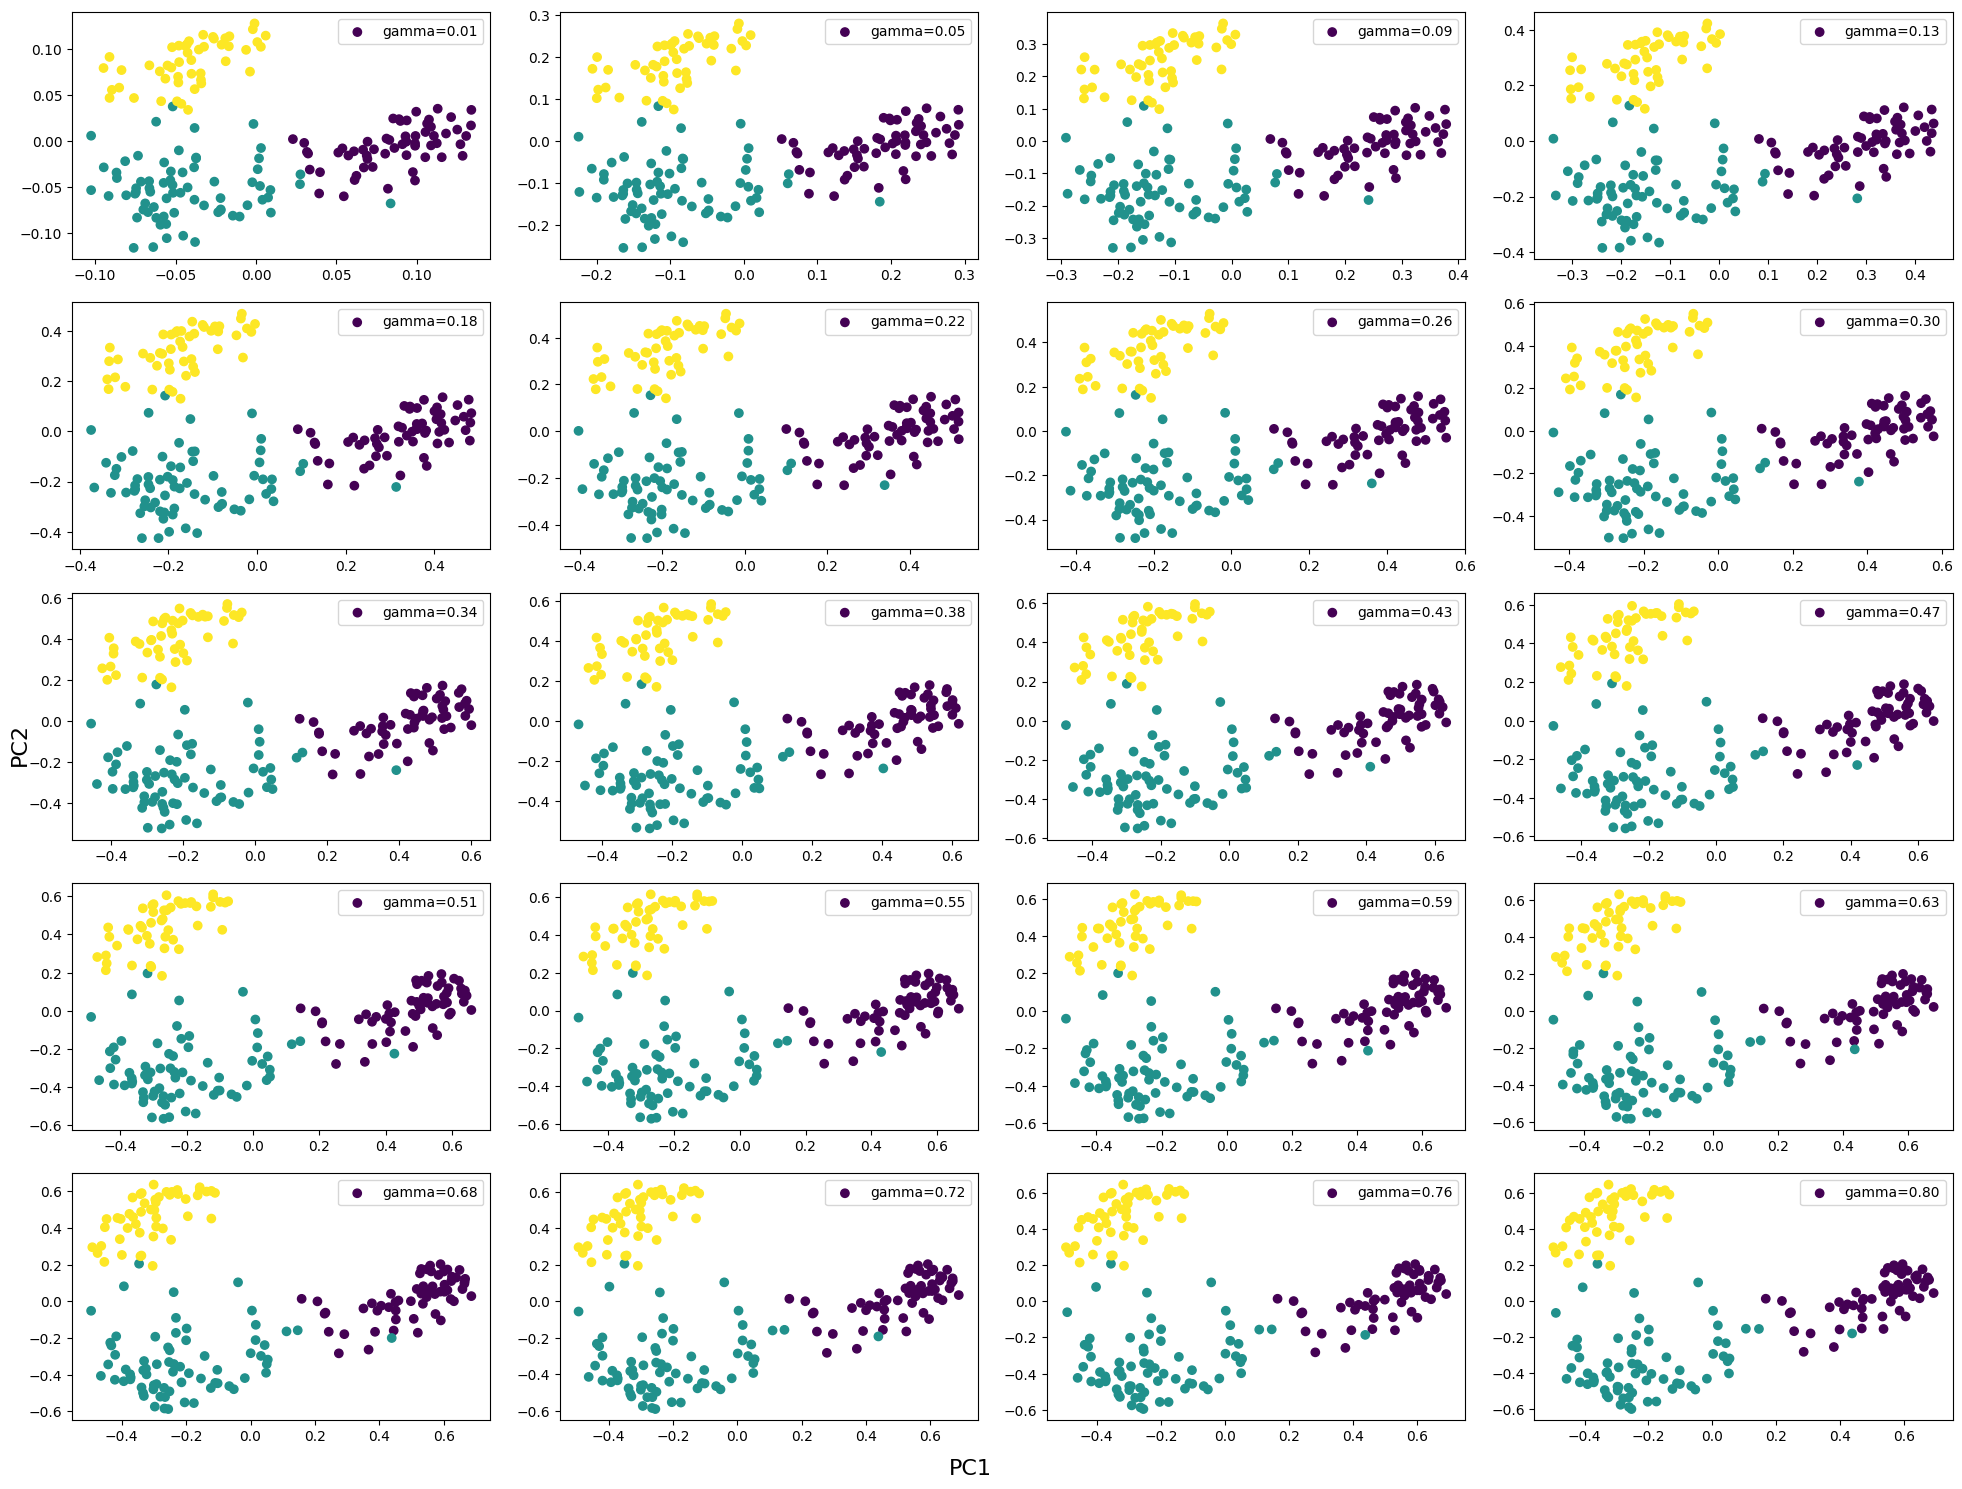

In [40]:
fig, ax = plt.subplots(5,4,figsize=(20,15))
ax=ax.flatten()

for i,j in enumerate(gamma_vals):
    transformer=KernelPCA(n_components=2, kernel='rbf', gamma=j)
    X_kp = transformer.fit_transform(X)
    clusters = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(X_kp)
    # plot the two components
    ax[i].scatter(X_kp[: ,0],X_kp[:,1],c=t_idx,label=f'gamma={j:.2f}')
    ax[i].legend()
    
fig.supxlabel('PC1',fontsize=16)
fig.supylabel('PC2',fontsize=16)
fig.tight_layout()

The coloring based on truth values show that still some points are being misclassified. Let's try one more method.

### UMAP and K-means clustering

Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) https://umap-learn.readthedocs.io/en/latest/

In [41]:
import umap

Silhouette score for 3 clusters: 0.79


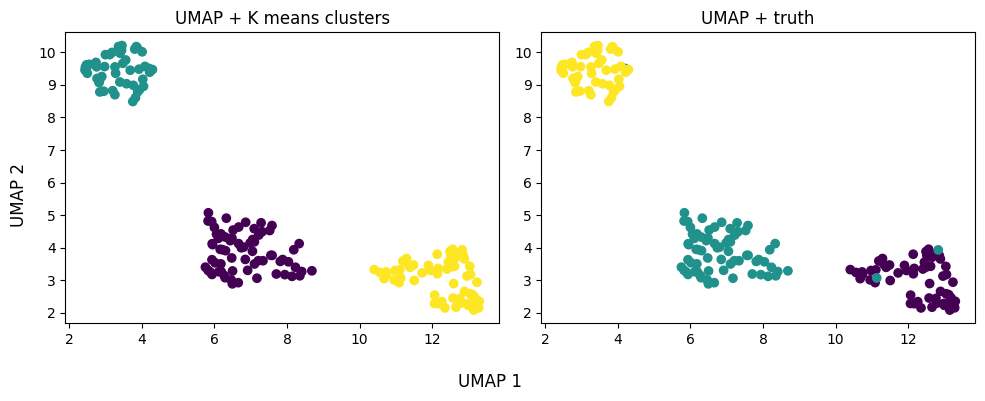

In [42]:
reducer = umap.UMAP(n_neighbors=20,min_dist=0.04,n_epochs=1000, n_components=2, metric='manhattan')
X_umap = reducer.fit_transform(X)

# cluster umap output
umap_clusters = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(X_umap)
print(f'Silhouette score for 3 clusters: {silhouette_score(X_umap,umap_clusters.labels_):.2f}')

# plot the projections
fig, ax=plt.subplots(1,2,figsize=(10,4))
ax=ax.flatten()
ax[0].scatter(X_umap[:, 0], X_umap[:, 1],c=umap_clusters.labels_,cmap='viridis')
ax[0].set_title('UMAP + K means clusters')
ax[1].scatter(X_umap[:, 0], X_umap[:, 1],c=t_idx,cmap='viridis')
ax[1].set_title('UMAP + truth')
fig.supylabel('UMAP 2')
fig.supxlabel('UMAP 1')
fig.tight_layout()
plt.show()

In [43]:
umap_clusters.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [44]:
t_idx

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

In [45]:
# match indices for visualization
umap_cl = [umap_clusters.labels_ == 2, umap_clusters.labels_ == 0, umap_clusters.labels_ == 1]
truth_labels = [0, 1, 2]
umap_cm = np.select(umap_cl, truth_labels)

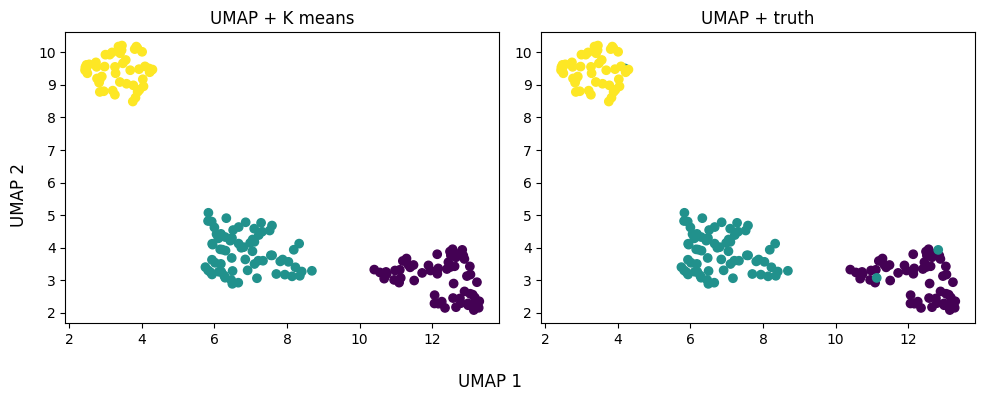

In [46]:
# plot the projections
fig, ax=plt.subplots(1,2,figsize=(10,4))
ax=ax.flatten()
ax[0].scatter(X_umap[:, 0], X_umap[:, 1],c=umap_cm,cmap='viridis')
ax[0].set_title('UMAP + K means')
ax[1].scatter(X_umap[:, 0], X_umap[:, 1],c=t_idx,cmap='viridis')
ax[1].set_title('UMAP + truth')
fig.supylabel('UMAP 2')
fig.supxlabel('UMAP 1')
fig.tight_layout()
plt.show()

In [47]:
# create labels dataframe
comp_df = pd.DataFrame({
    'umap_clusters': umap_cm,
    'target_labels': t_idx
})
comp_df.head()

,umap_clusters,target_labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [48]:
# check where the data is mismatched
mismatched_umap = comp_df[comp_df['umap_clusters'] != comp_df['target_labels']]
mismatched_umap

,umap_clusters,target_labels
61,2,1
73,0,1
121,0,1


In [49]:
print(f'Accuracy of classification using UMAP: {1-len(mismatched_umap.index)/len(w_df.index):.1%}')

Accuracy of classification using UMAP: 98.3%


#### Filter parent dataframe using mismatched indices

In [50]:
# Filter parent dataframe using these indices
prob_df_PCA = w_df.loc[mismatched_pca.index]
prob_df_PCA

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.980,1.59,450.0
68,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.020,1.93,750.0
70,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.310,3.50,985.0
83,13.05,3.86,2.32,22.5,85.0,1.65,1.59,0.61,1.62,4.80,0.840,2.01,515.0
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.160,2.63,937.0
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.930,3.69,465.0


In [51]:
# Filter parent dataframe using these indices
prob_df_kPCA = w_df.loc[mismatched_kpca.index]
prob_df_kPCA

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.980,1.59,450.0
68,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.020,1.93,750.0
70,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.310,3.50,985.0
83,13.05,3.86,2.32,22.5,85.0,1.65,1.59,0.61,1.62,4.80,0.840,2.01,515.0
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.160,2.63,937.0
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.930,3.69,465.0


In [52]:
# Filter parent dataframe using these indices
prob_df_umap = w_df.loc[mismatched_umap.index]
prob_df_umap

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0


Well, I am still unable to correctly cluster all the points. With UMAP, these were the same indices misclustered in the previous clustering example as well. For now, I will pause on this and move on...